# Pipeline Execution
This file is a file to run the whole pipeline according to discussion on Dec. 12
<br>
Procedure:
1. Pre-process data: Only use TF that are in gold standard, as discussed in class, prepare scores df
2. For each model, predict GRN edges (with scores), using optimum hyperparameter, then standardize weights, compile each score to a 'score' table, with columns sources of score (including uniform scores from random clf) and index the edges
3. Visualize PRC and ROC for each method for full nv dataframe
4. Statistically examine each method by randomly selecting target edges, getting the mean auprc and stdev, conduct tests (vs random t test, anova, tukey if anove rejected)

## 1. Load data and Pre-process

In [1]:
import pandas as pd
import grn_preds

# Read in expression, tf list, and gold files
nv_df = pd.read_csv('../dataset/yeast_networks/expression/NatVar.txt', sep='\t').set_index('Gene')
nv_tf = pd.read_csv('../dataset/yeast_networks/expression/NatVar_TF_names.txt', sep='\t', header=None)
nv_tf.columns = ['TF']

nv_gold = grn_preds.generate_gold_dataset(['../dataset/yeast_networks/gold/MacIsaac2.NatVar.txt', 
                                            '../dataset/yeast_networks/gold/YEASTRACT_Count3.NatVar.txt',
                                            '../dataset/yeast_networks/gold/YEASTRACT_Type2.NatVar.txt'])

# Filter tf list based on gold
nv_tf = nv_tf[nv_tf.loc[:, 'TF'].isin(set(nv_gold.loc[:, 'Regulator']))]

# Generate scores df
nv_scores_df = grn_preds.generate_possible_edges(nv_tf.loc[:, 'TF'], nv_df)
nv_scores_df = grn_preds.populate_actual_column(nv_scores_df, nv_gold)

## 2. Predict GRN edges with scores, using optimum hyperparameter or example hyperparameter, then store in compiled table

### 2a. Predict GRN edges with optimum hyperparameter (Takes about 10-12 hours, make sure back this file up!)

In [2]:
'''
for target in nv_df.index:
    lasso_edges, lasso_scores = grn_preds.grn_lasso(target, nv_tf.loc[:, 'TF'], nv_df, alphas = [0.001, 0.01, 0.1, 1, 10, 100], cv = 5)
    rf_edges, rf_scores = grn_preds.grn_regforest(target, nv_tf.loc[:, 'TF'], nv_df, n_estimators = 100, max_depth = 8, bootstrap = True, min_samples_leaf = 10, n_jobs = -1)
    svr_edges, svr_scores = grn_preds.grn_linear_svr(target, nv_tf.loc[:, 'TF'], nv_df)
    
    nv_scores_df.loc[lasso_edges, 'Lasso scores'] = abs(lasso_scores)
    nv_scores_df.loc[rf_edges, 'Regforest scores'] = rf_scores
    nv_scores_df.loc[svr_edges, 'SVR scores'] = abs(svr_scores)
    
nv_scores_df.to_csv('../dataset/nv_scores_df.csv')
'''
1

1

### 2b. Standardize weights so it has mean 0 and standard deviation 1, then add each weight with `abs(min(weight))`

In [3]:
'''
# Load nv_scores_df

nv_scores_df = pd.read_csv('../dataset/nv_scores_df.csv', index_col=0)
# Standardize scores for each scoring methods
methods = ["Lasso", "Regforest", "SVR"]
i = 0
print(len(set(nv_scores_df.loc[:, 'Target'])))
for method in methods:
    nv_scores_df.loc[:, f'Standardized {method} scores'] = 0

for target in list(set(nv_scores_df.loc[:, 'Target'])):
    if i % 10 == 0:
        print(i)
    for method in methods:
        new_index, standardized_scores = grn_preds.standardize_scores(target, nv_scores_df, method)
        nv_scores_df.loc[new_index, f'Standardized {method} scores'] = standardized_scores
    
    i += 1

nv_scores_df.to_csv('../dataset/nv_scores_df_stand.csv')
'''

'\n# Load nv_scores_df\n\nnv_scores_df = pd.read_csv(\'../dataset/nv_scores_df.csv\', index_col=0)\n# Standardize scores for each scoring methods\nmethods = ["Lasso", "Regforest", "SVR"]\ni = 0\nprint(len(set(nv_scores_df.loc[:, \'Target\'])))\nfor method in methods:\n    nv_scores_df.loc[:, f\'Standardized {method} scores\'] = 0\n\nfor target in list(set(nv_scores_df.loc[:, \'Target\'])):\n    if i % 10 == 0:\n        print(i)\n    for method in methods:\n        new_index, standardized_scores = grn_preds.standardize_scores(target, nv_scores_df, method)\n        nv_scores_df.loc[new_index, f\'Standardized {method} scores\'] = standardized_scores\n    \n    i += 1\n\nnv_scores_df.to_csv(\'../dataset/nv_scores_df_stand.csv\')\n'

In [4]:
'''
# Add 10k regforest scores
reg_forest_10k = pd.read_csv('../dataset/Regforest_main_NatVar.txt', sep = '\t', index_col=0)
nv_scores_df_stand.loc[:, 'Regforest 10k scores'] = reg_forest_10k.loc[:,'Regforest scores']
nv_scores_df_stand.loc[:, f'Standardized Regforest 10k scores'] = 0

i = 0
for target in list(set(nv_scores_df.loc[:, 'Target'])):
    if  i % 10 == 0:
        print(i)
    new_index, standardized_scores = grn_preds.standardize_scores(target, nv_scores_df_stand, 'Regforest 10k')
    nv_scores_df_stand.loc[new_index, f'Standardized Regforest 10k scores'] = standardized_scores
    
    i += 1
'''

"\n# Add 10k regforest scores\nreg_forest_10k = pd.read_csv('../dataset/Regforest_main_NatVar.txt', sep = '\t', index_col=0)\nnv_scores_df_stand.loc[:, 'Regforest 10k scores'] = reg_forest_10k.loc[:,'Regforest scores']\nnv_scores_df_stand.loc[:, f'Standardized Regforest 10k scores'] = 0\n\ni = 0\nfor target in list(set(nv_scores_df.loc[:, 'Target'])):\n    if  i % 10 == 0:\n        print(i)\n    new_index, standardized_scores = grn_preds.standardize_scores(target, nv_scores_df_stand, 'Regforest 10k')\n    nv_scores_df_stand.loc[new_index, f'Standardized Regforest 10k scores'] = standardized_scores\n    \n    i += 1\n"

In [5]:
'''
# Remove negative scores from weights in standardized scores by adding them with the smallest absolute value
nv_scores_df_stand.loc[:, 'Standardized Lasso scores'] = nv_scores_df_stand.loc[:, 'Standardized Lasso scores'] + abs(min(nv_scores_df_stand.loc[:, 'Standardized Lasso scores']))
nv_scores_df_stand.loc[:, 'Standardized Regforest scores'] = nv_scores_df_stand.loc[:, 'Standardized Regforest scores'] + abs(min(nv_scores_df_stand.loc[:, 'Standardized Regforest scores']))
nv_scores_df_stand.loc[:, 'Standardized SVR scores'] = nv_scores_df_stand.loc[:, 'Standardized SVR scores'] + abs(min(nv_scores_df_stand.loc[:, 'Standardized SVR scores']))
nv_scores_df_stand.loc[:, 'Standardized Regforest 10k scores'] = nv_scores_df_stand.loc[:, 'Standardized Regforest 10k scores'] + abs(min(nv_scores_df_stand.loc[:, 'Standardized Regforest 10k scores']))
'''

"\n# Remove negative scores from weights in standardized scores by adding them with the smallest absolute value\nnv_scores_df_stand.loc[:, 'Standardized Lasso scores'] = nv_scores_df_stand.loc[:, 'Standardized Lasso scores'] + abs(min(nv_scores_df_stand.loc[:, 'Standardized Lasso scores']))\nnv_scores_df_stand.loc[:, 'Standardized Regforest scores'] = nv_scores_df_stand.loc[:, 'Standardized Regforest scores'] + abs(min(nv_scores_df_stand.loc[:, 'Standardized Regforest scores']))\nnv_scores_df_stand.loc[:, 'Standardized SVR scores'] = nv_scores_df_stand.loc[:, 'Standardized SVR scores'] + abs(min(nv_scores_df_stand.loc[:, 'Standardized SVR scores']))\nnv_scores_df_stand.loc[:, 'Standardized Regforest 10k scores'] = nv_scores_df_stand.loc[:, 'Standardized Regforest 10k scores'] + abs(min(nv_scores_df_stand.loc[:, 'Standardized Regforest 10k scores']))\n"

In [6]:
# nv_scores_df_stand.to_csv('../dataset/nv_scores_df_stand.csv')

In [9]:
nv_scores_df_stand = pd.read_csv('../dataset/nv_scores_df_stand.csv', index_col = 0)

## 3. Visualize PRC and ROC for each method for full nv dataframe

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, precision_recall_curve

# Get fpr, tpr stat for different method
roc_dic = {'raw': {}, 'stand': {}}
prc_dic = {'raw': {}, 'stand': {}}

for method in ['Lasso', 'Regforest', 'SVR', 'Regforest 10k']:
    # Prep labeling so code is easy to follow
    actual_edges = nv_scores_df_stand.loc[:, 'Actual']
    raw_label = f'{method} scores'
    stand_label = f'Standardized {method} scores'
    
    # Get ROC and PRC stats
    raw_roc = roc_curve(actual_edges, nv_scores_df_stand.loc[:, raw_label])
    stand_roc = roc_curve(actual_edges, nv_scores_df_stand.loc[:, stand_label])
    raw_prc = precision_recall_curve(actual_edges, nv_scores_df_stand.loc[:, raw_label])
    stand_prc = precision_recall_curve(actual_edges, nv_scores_df_stand.loc[:, stand_label])
    
    # Get AUC for each curve
    auc_raw_roc = auc(raw_roc[0], raw_roc[1])
    auc_stand_roc = auc(stand_roc[0], stand_roc[1])
    auc_raw_prc = auc(raw_prc[1], raw_prc[0])
    auc_stand_prc = auc(stand_prc[1], stand_prc[0])
    
    # Store to respective dictionary
    roc_dic['raw'][raw_label] = (raw_roc[0], raw_roc[1], auc_raw_roc)
    roc_dic['stand'][stand_label] = (stand_roc[0], stand_roc[1], auc_stand_roc)
    prc_dic['raw'][raw_label] = (raw_prc[1], raw_prc[0], auc_raw_prc)
    prc_dic['stand'][stand_label] = (stand_prc[1], stand_prc[0], auc_stand_prc)


# Get stats for uniform scores

## Get ROC and PRC stats
uniform_roc = roc_curve(actual_edges, nv_scores_df_stand.loc[:, 'Uniform score'])
uniform_prc = precision_recall_curve(actual_edges, nv_scores_df_stand.loc[:, 'Uniform score'])

## Get AUC for each curve
uniform_auc_roc = auc(uniform_roc[0], uniform_roc[1])
uniform_auc_prc = auc(uniform_prc[1], uniform_prc[0])

## Store to respective dictionary
roc_dic['uniform score'] = (uniform_roc[0], uniform_roc[1], uniform_auc_roc)
prc_dic['uniform score'] = (uniform_prc[1], uniform_prc[0], uniform_auc_prc)

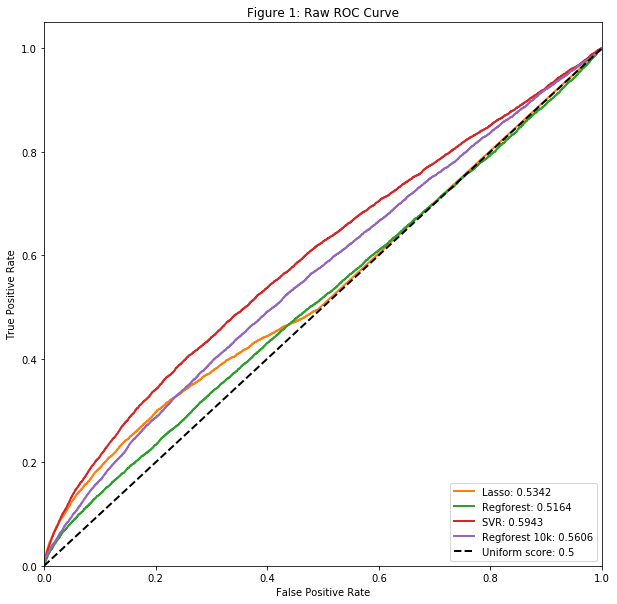

In [11]:
# Generate curves manually
raw_roc_fig = plt.figure(0, figsize=(10, 10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 1: Raw ROC Curve')

colors = ['C1', 'C2', 'C3', 'C4']
col_idx = 0
for method, stats in roc_dic['raw'].items():
    plt.plot(stats[0], stats[1], color = colors[col_idx], lw = 2, label = f'{method[:-7]}: {str(stats[2])[:6]}')
    col_idx += 1
col_idx = 0

plt.plot(roc_dic['uniform score'][0], roc_dic['uniform score'][1], color = 'black',
         lw = 2, linestyle = '--', label = f'Uniform score: {roc_dic["uniform score"][2]}')

plt.legend(loc = 'lower right')
plt.savefig('../figures/fig_1_raw_roc.png', format='png')
# plt.show()

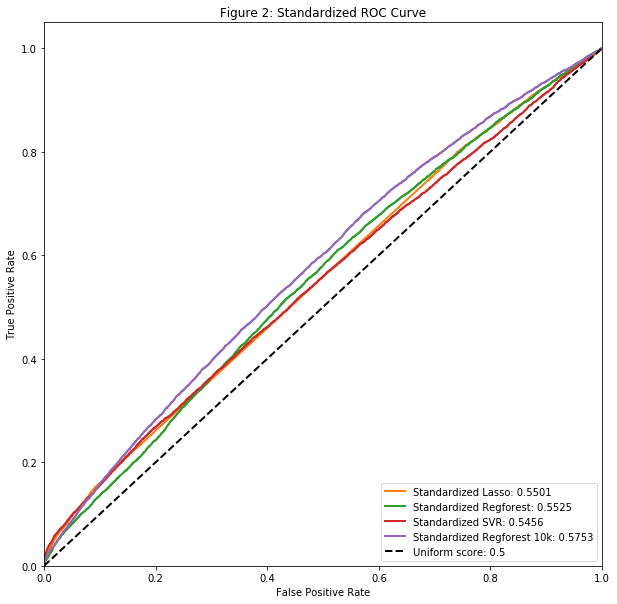

In [12]:
# Figure for Standardized ROC

stand_roc_fig = plt.figure(1, figsize=(10, 10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 2: Standardized ROC Curve')

colors = ['C1', 'C2', 'C3', 'C4']
col_idx = 0
for method, stats in roc_dic['stand'].items():
    plt.plot(stats[0], stats[1], color = colors[col_idx], lw = 2, label = f'{method[:-7]}: {str(stats[2])[:6]}')
    col_idx += 1
col_idx = 0

plt.plot(roc_dic['uniform score'][0], roc_dic['uniform score'][1], color = 'black',
         lw = 2, linestyle = '--', label = f'Uniform score: {roc_dic["uniform score"][2]}')

plt.legend(loc = 'lower right')
plt.savefig('../figures/fig_2_stand_roc.png', format='png')

# plt.show()

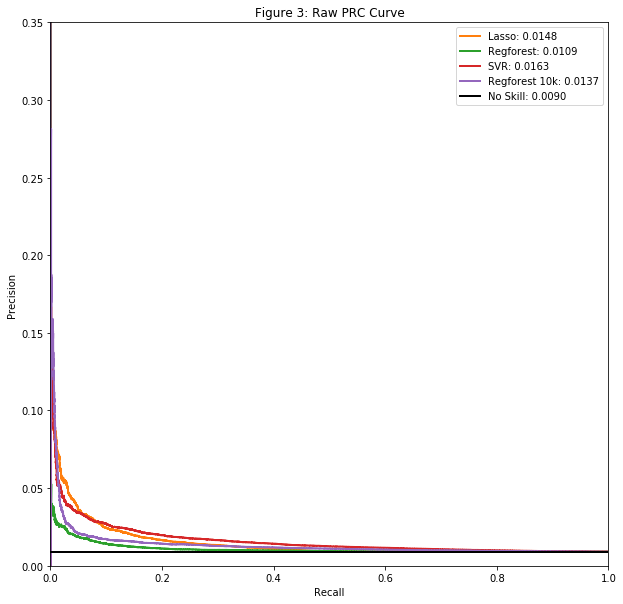

In [13]:
# Figure for raw PRC
raw_prc_fig = plt.figure(1, figsize=(10, 10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 0.35])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Figure 3: Raw PRC Curve')

colors = ['C1', 'C2', 'C3', 'C4']
col_idx = 0
for method, stats in prc_dic['raw'].items():
    plt.plot(stats[0], stats[1], color = colors[col_idx], lw = 2, label = f'{method[:-7]}: {str(stats[2])[:6]}')
    col_idx += 1

col_idx = 0

height = nv_scores_df.loc[:, 'Actual'].value_counts().to_dict()[1.0] / float(len(nv_scores_df))

plt.plot([0, 1], [height, height], color = 'black', lw = '2', label = f'No Skill: {str(height)[:6]}')

plt.legend(loc = 'upper right')
plt.savefig('../figures/fig_3_raw_prc.png', format='png')

# plt.show()



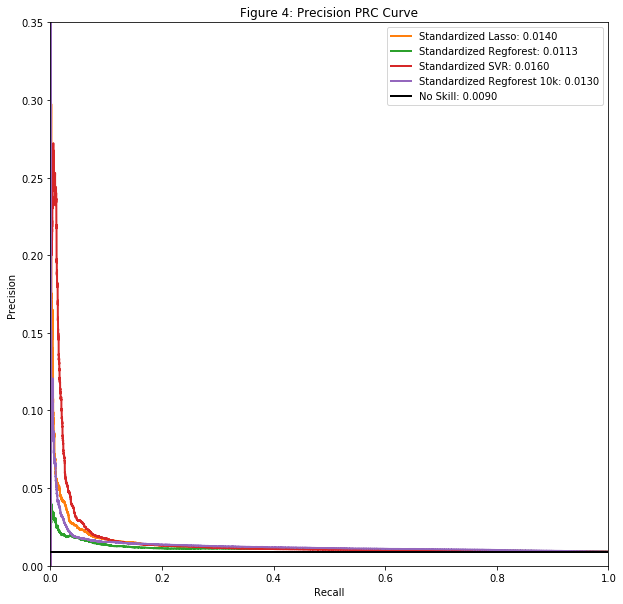

In [14]:
# Figure for Standardized PRC

stand_prc_fig = plt.figure(1, figsize=(10, 10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 0.35])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Figure 4: Precision PRC Curve')

colors = ['C1', 'C2', 'C3', 'C4']
col_idx = 0
for method, stats in prc_dic['stand'].items():
    plt.plot(stats[0], stats[1], color = colors[col_idx], lw = 2, label = f'{method[:-7]}: {str(stats[2])[:6]}')
    col_idx += 1
col_idx = 0

plt.plot([0, 1], [height, height], color = 'black', lw = '2', label = f'No Skill: {str(height)[:6]}')

plt.legend(loc = 'upper right')
plt.savefig('../figures/fig_4_stand_prc.png', format='png')

# plt.show()

## 4. Statistically examine each method by randomly selecting target edges
Getting the mean auprc and stdev, conduct tests (vs random t test, anova, tukey if anova rejected)

In [ ]:
'''
# We select 100 target genes for each sampling, and we sample 100 times from the scores, then we get each method's auc for each sampling, for ROC and PRC.
import random

# Prepare score dictionary / list
methods = ['Lasso', 'Regforest', 'SVR', 'Regforest 10k', 'Standardized Lasso', 'Standardized Regforest', 'Standardized SVR', 'Standardized Regforest 10k']
score_dic = {'auroc': {}, 'auprc': {}}

for method in methods:
    score_dic['auroc'][method] = []
    score_dic['auprc'][method] = []

for i in range(100):
    print(i)
    sampled_targets = random.sample(list(set(nv_scores_df_stand.loc[:, 'Target'])), 100)
    subset_df = nv_scores_df_stand[nv_scores_df_stand.loc[:, 'Target'].isin(sampled_targets)]

    for method in methods:
        method_auroc = grn_preds.generate_auroc(subset_df.loc[:, 'Actual'], subset_df.loc[:, f'{method} scores'], show = False)
        method_auprc = grn_preds.generate_auprc(subset_df.loc[:, 'Actual'], subset_df.loc[:, f'{method} scores'], show = False)

        score_dic['auroc'][method].append(method_auroc)
        score_dic['auprc'][method].append(method_auprc)

# Store to csv file
auroc_df = pd.DataFrame.from_dict(score_dic['auroc'])
auprc_df = pd.DataFrame.from_dict(score_dic['auprc'])

auroc_df.to_csv('../dataset/auroc_sampling_scores.csv', index=False)
auprc_df.to_csv('../dataset/auprc_sampling_scores.csv', index=False)
'''

In [20]:
# Load auroc and auprc sampling df
auroc_df = pd.read_csv('../dataset/auroc_sampling_scores.csv')
auprc_df = pd.read_csv('../dataset/auprc_sampling_scores.csv')

In [22]:
auroc_df

,Lasso,Regforest,SVR,Regforest 10k,Standardized Lasso,Standardized Regforest,Standardized SVR,Standardized Regforest 10k
0,0.484642,0.503501,0.553614,0.582823,0.519358,0.579974,0.518674,0.600763
1,0.508979,0.515845,0.580765,0.580510,0.567931,0.553311,0.538724,0.595255
2,0.543361,0.514147,0.615594,0.590797,0.555316,0.572360,0.532923,0.628408
3,0.483935,0.498065,0.503571,0.530869,0.534158,0.492535,0.507376,0.535209
4,0.570109,0.531367,0.586158,0.559510,0.530519,0.569302,0.548395,0.569845
5,0.541363,0.542546,0.620956,0.576185,0.559739,0.561193,0.582751,0.580545
6,0.512541,0.514374,0.614782,0.558096,0.558677,0.561957,0.549183,0.590355
7,0.555772,0.487475,0.637811,0.570472,0.577706,0.538200,0.565054,0.598044
8,0.461242,0.484916,0.581200,0.543098,0.563889,0.509460,0.515979,0.538847
9,0.517530,0.526649,0.573184,0.554191,0.576595,0.500722,0.537535,0.530978
